# Monte Carlo Off-Policy

*Description:* Este notebook describe un experimento de aprendizaje por refuerzo utilizando el algoritmo de Monte Carlo Off-Policy.
El propósito de este análisis es explicar la implementación del agente y probar con dos entornos (FrozenLake y Taxi) que funciona correctamente.

    Author: Iván Martínez Cuevas y Antonio Orenes Lucas
    Email: ivan.martinezc@um.es y antonio.orenesl@um.es
    Date: 2025/02/12

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html

# Introducción a Monte Carlo Off-Policy

Monte Carlo Off-Policy es un algoritmo de aprendizaje por refuerzo que aprende el valor de las acciones (función Q) mediante la experiencia obtenida en episodios completos, pero a diferencia del método On-Policy, la política que genera las experiencias (política de comportamiento) es distinta de la política que se está aprendiendo (política objetivo). 

Este enfoque permite reutilizar datos de estrategias anteriores o entrenar con datos obtenidos de múltiples fuentes.

## Componentes Clave
1. Agente (`Agent`, `TabularAgent`, `MonteCarloAgent`, `MonteCarloOffPolicyAgent`):
  * La clase `Agent` define la estructura general de un agente de RL.
  * `TabularAgent` especializa el agente para entornos con espacios de estados y acciones discretos, utilizando una tabla Q para almacenar los valores de acción.
  * `MonteCarloOffPolicyAgent` implementa el algoritmo específico con **importance sampling** para corregir las diferencias entre la política de comportamiento y la política objetivo.

2. Políticas (`Policy`, `EpsilonGreedyPolicy`):
  * La clase `Policy` define la estructura general de una política.
  * `EpsilonGreedyPolicy` permite equilibrar la exploración y la explotación en la política objetivo.
  * En este método, se distinguen:
    * **Política de comportamiento**: Genera las experiencias y puede explorar más.
    * **Política objetivo**: Se actualiza para optimizar la toma de decisiones.

3. Importance Sampling:
  * Se usa para ponderar la influencia de cada episodio basado en la diferencia entre la política de comportamiento y la política objetivo.
  * Se pueden usar dos variantes:
    * **Importance Sampling Ordinario**: Ajusta cada actualización con el ratio entre ambas políticas.
    * **Importance Sampling Ponderado**: Normaliza las actualizaciones acumulando pesos.

4. Entorno (`gym.Env`):
  * El entorno de Gymnasium donde el agente interactúa.
  * Los entornos probados son:
    * **FrozenLake**: Entorno de cuadrícula donde el agente debe navegar desde un punto de inicio hasta un destino sin caer en agujeros.
    * **Taxi**: Simula un taxi que recoge un pasajero y lo transporta hasta su destino.

## Preparación del entorno
La preparación consta de las siguientes partes:

* **Instalación de Dependencias**: Se instalan las librerías necesarias para utilizar el entorno gymnasium para la simulación, con el objetivo de crear un ambiente controlado para que el agente pueda interactuar.

* **Importación de Librerías**: Se importan las bibliotecas necesarias como numpy para el manejo de matrices y matplotlib para la visualización de los resultados.

* **Importación de los entornos**: Se cargan dos versiones del entorno "FrozenLake": una de 4x4 y otra de 8x8. Ambas versiones no son resbaladizas, lo que facilita la comprensión de los resultados, dado que el entorno resbaladizo podría dificultar la comprensión inicial del aprendizaje. Además, se carga el entorno "Taxi-V3".

In [1]:
#@title Copiar el repositorio.

!git clone https://github.com/Imartinezcuevas/RL_MC_OL.git
!cd k_brazos_MC_OL/

Clonando en 'RL_MC_OL'...
remote: Enumerating objects: 292, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 292 (delta 5), reused 3 (delta 1), pack-reused 275 (from 1)
Recibiendo objetos: 100% (292/292), 2.08 MiB | 5.94 MiB/s, listo.
Resolviendo deltas: 100% (154/154), listo.
/bin/bash: línea 1: cd: k_brazos_MC_OL/: No existe el archivo o el directorio


In [31]:
#@title Importamos todas las clases y funciones

#@title Instalamos gym
#!pip install 'gym[box2d]==0.20.0'

## Instalación de algunos paquetes.
#!apt-get update
## Para usar gymnasium[box2d]
#!apt install swig
#!pip install gymnasium[box2d]

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('RL_MC_OL/src')

# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
from typing import List
import random
import os

from agentes import Agent, TabularAgent, MonteCarloAgent, MonteCarloOffPolicyAgent, MonteCarloOnPolicyAgent
from politicas import Policy, EpsilonGreedyPolicy
from plotting import plot_reward_ratio, plot_episode_lengths

seed_value= 100
random.seed(seed_value)
np.random.seed(seed_value)
np.random.default_rng(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/antonio/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', 'RL_MC_OL/src', 'RL_MC_OL/src', 'RL_MC_OL/src', 'RL_MC_OL/src']


In [33]:
name = 'FrozenLake-v1'

env4 = gym.make(name, is_slippery=False, map_name="4x4", render_mode="ansi") # No resbaladizo para entender mejor los resultados.
env4.reset(seed=seed_value)
env8 = gym.make(name, is_slippery=False, map_name="8x8", render_mode="ansi") # No resbaladizo para entender mejor los resultados.
env_taxi = gym.make('Taxi-v3', render_mode="ansi")

## Función de entrenamiento
Se ha modificado el bucle utilizado como referencia para poder usar los agentes desarrollados.

En resumen, la función `train_monte_carlo_off_policy` simula múltiples episodios de interacción entre el agente y el entorno, utilizando **importance sampling** para corregir las diferencias entre la política de comportamiento y la política objetivo.



In [34]:
def train_monte_carlo_off_policy(agent, env, num_episodes=50000, max_step_per_episode=1000):
    evaluation_history = []
    step_display = num_episodes / 10

    for episode in tqdm(range(num_episodes)):
        state, info = env.reset(seed=100)
        agent.start_episode()

        done = False
        step = 0
        episode_reward = 0
        while not done and step < max_step_per_episode:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            agent.update(state, action, next_state, reward, done, info)
            episode_reward += reward
            state = next_state
            step += 1

        agent.end_episode(episode_reward, step)

        if episode % step_display == 0 and episode != 0:
            success_rate, avg_length, avg_reward = evaluate_agent(agent, env, num_episodes=100)
            print(f"\nPorcentaje de éxito: {success_rate}, Longitud media del episodio: {avg_length}, Recompensa media: {avg_reward}")

    return agent

## Función de evaluación
La función `evaluate_agent` evalúa el rendimiento del agente ejecutando múltiples episodios con una política determinista (epsilon=0) y calcula métricas como la tasa de éxito, longitud promedio del episodio y recompensa promedio.

In [35]:
def evaluate_agent(agent, env, num_episodes=100):
    success_count = 0
    episode_lengths = []
    total_rewards = []

    # Guardamos el valor original de epsilon
    original_epsilon = agent.policy.epsilon

    # Establecemos epsilon a 0 para evaluación determinista
    agent.policy.epsilon = 0.0

    for _ in range(num_episodes):
        state, _ = env.reset(seed=100)
        done = False
        steps = 0
        episode_reward = 0
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            steps += 1
            episode_reward += reward
            state = next_state
            if terminated and reward > 0:
                success_count += 1
        episode_lengths.append(steps)
        total_rewards.append(episode_reward)

    # Restauramos el valor original de epsilon
    agent.policy.epsilon = original_epsilon

    success_rate = success_count / num_episodes
    avg_episode_length = np.mean(episode_lengths)
    avg_reward = np.mean(total_rewards)
    return success_rate, avg_episode_length, avg_reward

## FrozenLake - 4x4

FrozenLake 4x4 es un entorno que simula un lago congelado. Uno de las características clave de este entorno es que las recompensas son dispersas. Esto puede hacer que el agente tarde muchos episodios en recibir una recompensa positiva, lo que dificulta la actualización de la función de valor.

Aún así, al ser un mapa pequeño no representa muchos problemas a la hora de encontrar la política óptima.

 10%|█         | 5192/50000 [00:05<01:13, 606.50it/s] 


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0


 21%|██        | 10282/50000 [00:09<00:35, 1127.67it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0


 31%|███       | 15310/50000 [00:12<00:31, 1107.45it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0


 41%|████      | 20343/50000 [00:14<00:27, 1076.11it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0


 51%|█████     | 25270/50000 [00:17<00:21, 1127.54it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0


 60%|██████    | 30241/50000 [00:20<00:17, 1123.93it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0


 71%|███████   | 35378/50000 [00:23<00:13, 1104.64it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0


 80%|████████  | 40212/50000 [00:26<00:08, 1135.31it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0


 90%|█████████ | 45225/50000 [00:29<00:04, 1152.64it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0


100%|██████████| 50000/50000 [00:31<00:00, 1573.56it/s]


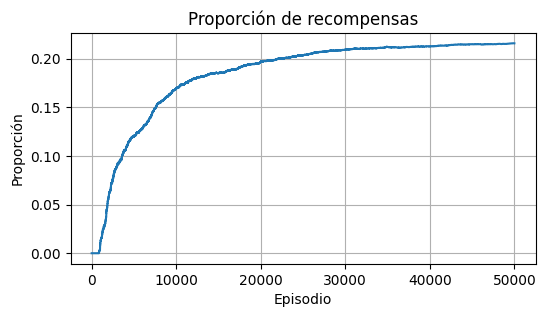

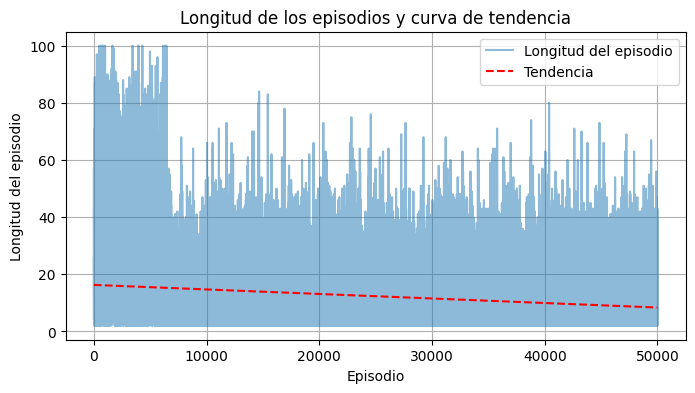

In [38]:
# Crear la política de comportamiento con epsilon 0.4
behavior_policy = EpsilonGreedyPolicy(env4.action_space, epsilon=0.4, epsilon_decay=0.99995, epsilon_min=0.01)

# Crear la política objetivo greedy
target_policy = EpsilonGreedyPolicy(env4.action_space, epsilon=0.0)

# Crear el agente usando MonteCarloOffPolicyAgent
agent_env4_off = MonteCarloOffPolicyAgent(env4, policy=behavior_policy, gamma=1.0, first_visit=False, target_policy=target_policy)

# Entrenamos al agente
trained_agent_env4_off = train_monte_carlo_off_policy(agent_env4_off, env4, num_episodes=50000)

stats_off = trained_agent_env4_off.stats()

# Graficamos los resultados
plot_reward_ratio(stats_off["reward_ratio"])
plot_episode_lengths(stats_off["episode_lengths"])

Las gráficas muestran el comportamiento del agente entrenado con Monte Carlo On-Policy en el entorno FrozenLake 4x4.

* Primera gráfica:

    Esta gráfica representa la proporción acumulada de recompensas obtenidas a lo largo de los episodios.

    La proporción de recompensas se estabiliza muy pronto, es decir, aprende muy rápido, debido a la capacidad de usar experiencias generadas con diferentes políticas. 

    Esta proporción se mantiene estable y no crece significativamente. Esto puede deberse a que el importance sampling introduce varianza en la actualización de valores Q, lo que afecta la convergencia.

* Segunda gráfica: 

    Esta gráfica ilustra la cantidad de pasos necesarios para completar un episodio.

    La variación en la longitud d elos episodios es menos pronunciada. 

    No se reduce la cantidad de pasos por episodio, lo que sugiere que no se han encontrado trayectorias óptimas.

Comparando estas gráficas con el notebook Monte Carlo On-Policy, se puede apreciar que Off-Policy aprende más rápido al principio, pero la proporción de recompensas se estanca hasta aproximadamente un 0.22, mientras que On-Policy llega hasta el 0.65 aproximadamente, sugiriendo que el importance sampling puede estar afectando negativamente el aprendizaje.

También hay que destacar que Off-Policy reduce en menor medida la cantidad de pasos por episodio.

In [39]:
# Política Greedy basada en los valores Q aprendidos en Off-Policy
def pi_star_from_Q(env, Q):
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, info = env.reset(seed=100) # start in top-left, = 0
    actions = ""
    while not done:
        action = np.argmax(Q[state, :])
        actions += f"{action}, "
        pi_star[state, action] = action
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    return pi_star, actions

Q_off = trained_agent_env4_off.get_action_values()
pi_off, actions_off = pi_star_from_Q(env4, Q_off)

print("Política óptima obtenida (Off-Policy)\n", pi_off, f"\n Acciones {actions_off} \n Para el siguiente grid\n", env4.render())
print()

Política óptima obtenida (Off-Policy)
 [[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 
 Acciones 1, 1, 2, 2, 1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,  
 Para el siguiente grid
   (Left)
SFFF
FHFH
FFFH
HFFG




TODO - Funciona mal el 4x4, primero arreglar eso y luego el 8x8 y comentar la solución
### **FrozenLake - 8x8 (Monte Carlo Off-Policy)**

Con FrozenLake 8x8 aumentamos el espacio de estados. Mucho mayor que el de 4x4, pasando de 16 estados a 64. Esto significa que el agente debe explorar un espacio más amplio para encontrar la ruta óptima.

Además, al ser la ruta más larga, aumenta la duración de los episodios y, por tanto, se ralentiza el aprendizaje, especialmente para los métodos como Monte Carlo que actualizan la función de valor al final de cada episodio.

**Problemas y soluciones en Off-Policy**
1. **Exploración alta (ϵ=1 en la política de comportamiento)**
  * **Problema:** En un entorno tan grande, el agente puede quedarse atrapado en rutas subóptimas o no llegar nunca al objetivo.
  * **Solución:** Se ha establecido `epsilon=1` en la política de comportamiento para explorar completamente el entorno al principio. Esto es crucial para descubrir rutas óptimas antes de explotar lo aprendido.

2. **Inicialización optimista**
  * **Problema:** El agente tarda mucho en asociar valores positivos a las acciones correctas.
  * **Solución:** Se utiliza inicialización optimista de los valores \( Q \), asignando un valor alto inicialmente. Esto incentiva al agente a probar acciones desconocidas porque asume que todas son valiosas.


 10%|█         | 5099/50000 [00:07<02:01, 368.82it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0


 20%|██        | 10095/50000 [00:14<01:37, 410.10it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0


 30%|███       | 15116/50000 [00:22<01:17, 449.79it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0


 40%|████      | 20130/50000 [00:29<01:12, 414.77it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0


 50%|█████     | 25137/50000 [00:36<00:56, 442.87it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0


 60%|██████    | 30110/50000 [00:43<00:45, 435.38it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0


 70%|███████   | 35124/50000 [00:50<00:35, 423.68it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0


 80%|████████  | 40100/50000 [00:57<00:25, 386.33it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0


 90%|█████████ | 45112/50000 [01:04<00:11, 418.31it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0


100%|██████████| 50000/50000 [01:10<00:00, 705.62it/s]


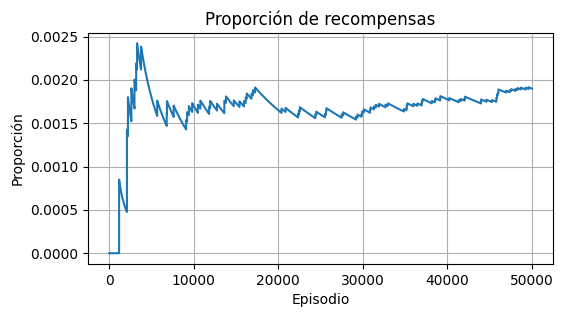

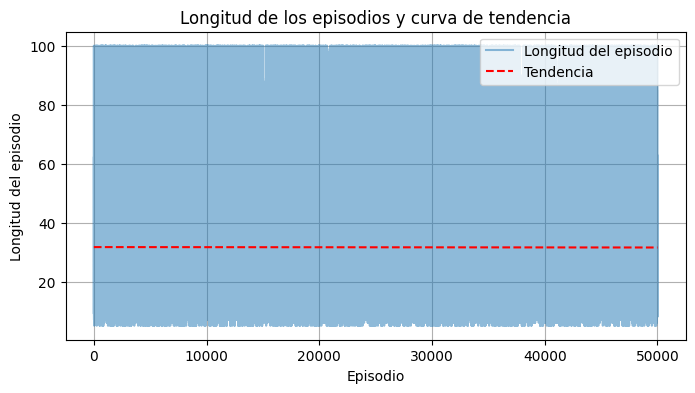

In [44]:
# Crear la política de comportamiento con epsilon 1 para explorar completamente el entorno al principio
behavior_policy_8x8 = EpsilonGreedyPolicy(env8.action_space, epsilon=1.0, epsilon_decay=0.9993, epsilon_min=0.01)

# Crear la política objetivo greedy
target_policy_8x8 = EpsilonGreedyPolicy(env8.action_space, epsilon=0.0)

# Crear el agente usando MonteCarloOffPolicyAgent con inicialización optimista
agent_env8_off = MonteCarloOffPolicyAgent(env8, policy=behavior_policy_8x8, gamma=1.0, first_visit=False, 
                                          target_policy=target_policy_8x8, optimistic_init=True, init_value=10.0)

# Entrenamos al agente
trained_agent_env8_off = train_monte_carlo_off_policy(agent_env8_off, env8, num_episodes=50000, max_step_per_episode=200)

stats_8x8_off = trained_agent_env8_off.stats()

# Graficamos los resultados
plot_reward_ratio(stats_8x8_off["reward_ratio"])
plot_episode_lengths(stats_8x8_off["episode_lengths"])

In [45]:
# Obtener los valores Q aprendidos en Off-Policy
Q_off_8x8 = trained_agent_env8_off.get_action_values()

# Obtener la política óptima a partir de Q
target_policy_8x8, actions_off_8x8 = pi_star_from_Q(env8, Q_off_8x8)

# Mostrar los resultados
print("Política óptima obtenida (Off-Policy)\n", target_policy_8x8, 
      f"\n Acciones {actions_off_8x8} \n Para el siguiente grid\n", env8.render())
print()

Política óptima obtenida (Off-Policy)
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 

### **Taxi - Monte Carlo Off-Policy**

El entorno **Taxi** tiene un espacio de estados discreto pero complejo, definido por la ubicación del taxi, la ubicación del pasajero y el destino del pasajero.

El agente recibe **recompensas por acciones correctas** y **penalizaciones por acciones incorrectas**. Esto introduce un elemento que requiere que el agente evite acciones negativas.

Para abordar este problema en **Monte Carlo Off-Policy**, se han tomado las siguientes decisiones:

* **Exploración alta en la política de comportamiento (`ϵ=0.9`)**: Asegura una exploración extensa al inicio y la prolongamos para evitar que el agente quede atrapado en rutas subóptimas.
* **Inicialización optimista (`Q=5.0`)**: Incentivamos al agente a explorar activamente, lo que puede ayudar a descubrir rutas y estrategias eficientes.


 10%|█         | 5023/50000 [00:42<14:50, 50.52it/s] 


Porcentaje de éxito: 0.0, Longitud media del episodio: 200.0, Recompensa media: -200.0


 20%|██        | 10024/50000 [01:25<12:54, 51.61it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 200.0, Recompensa media: -200.0


 30%|███       | 15017/50000 [02:05<11:53, 49.04it/s] 


Porcentaje de éxito: 0.0, Longitud media del episodio: 200.0, Recompensa media: -200.0


 40%|████      | 20019/50000 [02:47<09:24, 53.10it/s] 


Porcentaje de éxito: 0.0, Longitud media del episodio: 200.0, Recompensa media: -200.0


 50%|█████     | 25020/50000 [03:28<08:05, 51.45it/s] 


Porcentaje de éxito: 0.0, Longitud media del episodio: 200.0, Recompensa media: -200.0


 60%|██████    | 30020/50000 [04:08<05:58, 55.78it/s] 


Porcentaje de éxito: 0.0, Longitud media del episodio: 200.0, Recompensa media: -200.0


 70%|███████   | 35016/50000 [04:45<04:22, 56.99it/s] 


Porcentaje de éxito: 0.0, Longitud media del episodio: 200.0, Recompensa media: -200.0


 80%|████████  | 40018/50000 [05:23<02:58, 56.01it/s] 


Porcentaje de éxito: 0.0, Longitud media del episodio: 200.0, Recompensa media: -200.0


 90%|█████████ | 45018/50000 [06:03<01:35, 52.02it/s] 


Porcentaje de éxito: 0.0, Longitud media del episodio: 200.0, Recompensa media: -200.0


100%|██████████| 50000/50000 [06:43<00:00, 123.94it/s]


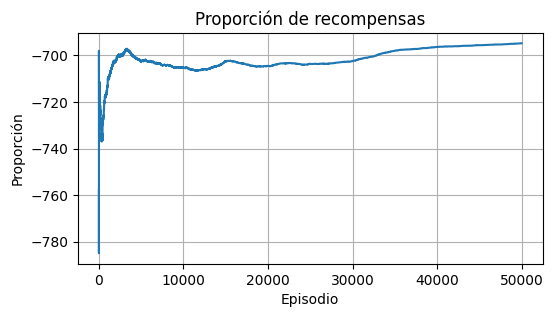

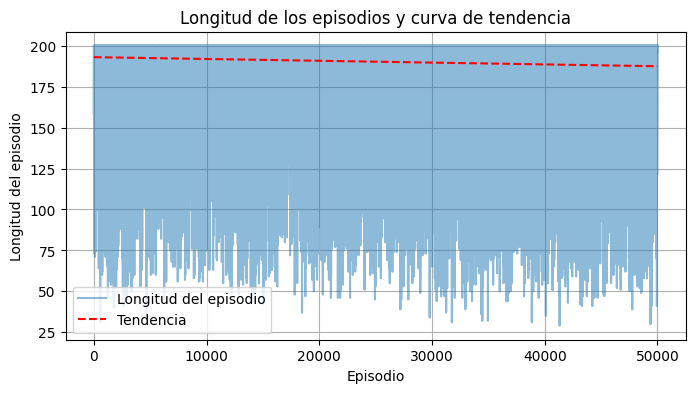

In [42]:
# Crear la política de comportamiento con epsilon alto
behavior_policy_taxi = EpsilonGreedyPolicy(env_taxi.action_space, epsilon=0.9, epsilon_decay=0.9999, epsilon_min=0.01)

# Crear la política objetivo greedy
target_policy_taxi = EpsilonGreedyPolicy(env_taxi.action_space, epsilon=0.0)

# Crear el agente usando MonteCarloOffPolicyAgent con inicialización optimista
agent_taxi_off = MonteCarloOffPolicyAgent(env_taxi, policy=behavior_policy_taxi, gamma=0.95, first_visit=False, 
                                          target_policy=target_policy_taxi, optimistic_init=True, init_value=5.0)

# Entrenamos al agente
trained_agent_taxi_off = train_monte_carlo_off_policy(agent_taxi_off, env_taxi, num_episodes=50000)

stats_taxi_off = trained_agent_taxi_off.stats()

# Graficamos los resultados
plot_reward_ratio(stats_taxi_off["reward_ratio"])
plot_episode_lengths(stats_taxi_off["episode_lengths"])

Las gráficas muestran el comportamiento del agente entrenado con Monte Carlo Off-Policy en el entorno Taxi-v3.

* **Primera gráfica:**

    Esta gráfica representa la proporción acumulada de recompensas obtenidas a lo largo de los episodios.

    El agente comienza con recompensas muy negativas (~-780 en los primeros episodios). Esto es esperable en Taxi-v3, ya que al inicio el agente realiza muchas acciones incorrectas y recibe penalizaciones.

    Pico inicial (~5000 episodios): Se observa una mejora rápida inicial, pero luego hay una estabilización con fluctuaciones. 

    Estancamiento entre ~10,000 y ~30,000 episodios. A diferencia del entrenamiento On-Policy, donde la mejora es más estable, aquí las recompensas fluctúan bastante. Esto puede indicar problemas con la convergencia del agente Off-Policy.

* **Segunda gráfica:**

    Esta gráfica ilustra la cantidad de pasos necesarios para completar un episodio.

    La mayoría de los episodios tienen la máxima longitud (~200 pasos)

    En Taxi-v3, un episodio termina cuando el taxi deja al pasajero correctamente. Como casi todos los episodios duran 200 pasos, significa que el agente no está encontrando rutas eficientes. La línea de tendencia es casi constante

    A diferencia de On-Policy, donde la longitud de los episodios disminuye con el tiempo, aquí el agente no parece mejorar en términos de eficiencia.

    Hay algunos casos en los que el agente completa el episodio rápidamente, lo que indica que ocasionalmente aprende estrategias correctas. Sin embargo, la mayoría de las veces toma el máximo número de pasos, lo que sugiere que la política aprendida es deficiente.

In [43]:
# Obtener los valores Q aprendidos en Off-Policy
Q_off_taxi = trained_agent_taxi_off.get_action_values()

# Obtener la política óptima a partir de Q
target_policy_taxi, actions_off_taxi = pi_star_from_Q(env_taxi, Q_off_taxi)

# Mostrar los resultados
print("Política óptima obtenida (Off-Policy)\n", target_policy_taxi, 
      f"\n Acciones {actions_off_taxi} \n Para el siguiente grid\n", env_taxi.render())
print()

Política óptima obtenida (Off-Policy)
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 
 Acciones 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,  
 Para el siguiente grid
 +---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)


